# MCMC sample
Please, install emcee and corner
- pip install emcee
- pip install corner

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pylab
import matplotlib.pyplot as plt
import emcee

In [2]:
a_t=1.2
phi_t=2.6
tlen=10
N = 30
x = np.sort(tlen*np.random.rand(N))
knownstd=np.sqrt(np.abs((x-tlen/2)/100.0))
unsys=0.2
xl=np.linspace(0,tlen,1000)
ytrue=a_t*np.sin(xl+phi_t)
yerr = np.random.normal(0.0,knownstd,N)
y = a_t*np.sin(x+phi_t)+yerr+np.random.normal(0.0,unsys,N)
plt.rcParams["font.size"] = 16

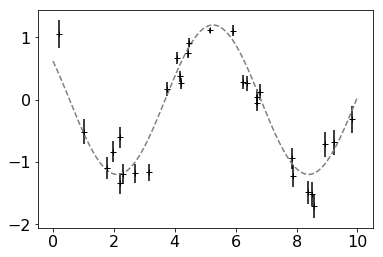

In [3]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.errorbar(x,y,yerr=knownstd,color="black",fmt="+")
ax.plot(xl,ytrue,color="gray",ls="dashed",label="Input")
plt.show()

In [4]:
def lnlike(p, t, d, derr):
    a, phi, sigunk = p
    model = a*np.sin(t+phi)
    inv_sigma2 = 1.0/(derr**2 + sigunk**2)
    return -0.5*(np.sum((d-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [5]:
def lnprior(p):
    a, phi, sigunk = p
    if 0.0 < a < 10.0 and 0.0 < phi <= 2.0*np.pi and 0.0 < sigunk < 10.0:
        return 0.0
    return -np.inf

In [6]:
def lnprob(p, t, d, derr):
    lp = lnprior(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(p, t, d, derr)

In [7]:
ndim, nwalkers = 3, 100
a_in=0.5
phi_in=3.0
unsys_in=1.0
pos = [[a_in,phi_in,unsys_in] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [8]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

In [9]:
sampler.run_mcmc(pos, 10000);

In [10]:
samples = sampler.chain[:, 1000:1100, :].reshape((-1, ndim))

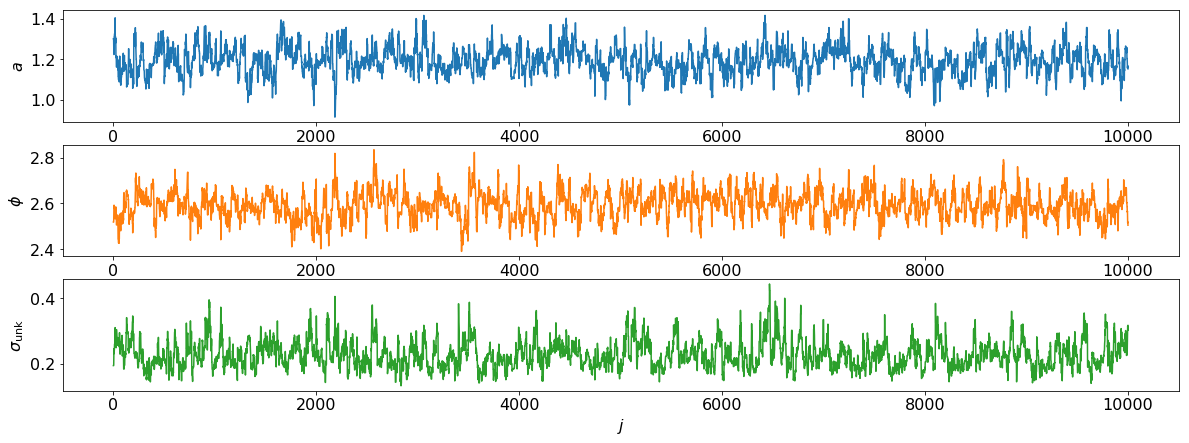

In [11]:
fig=plt.figure(figsize=(20,7))
ax=fig.add_subplot(311)
ax.plot(samples[:,0],color="C0")
pylab.ylabel("$a$",fontsize=16)
ax=fig.add_subplot(312)
ax.plot(samples[:,1],color="C1")
pylab.ylabel("$\\phi$",fontsize=16)
ax=fig.add_subplot(313)
ax.plot(samples[:,2],color="C2")
pylab.ylabel("$\\sigma_\\mathrm{unk}$",fontsize=16)
pylab.xlabel("$j$",fontsize=16)
plt.show()

In [12]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

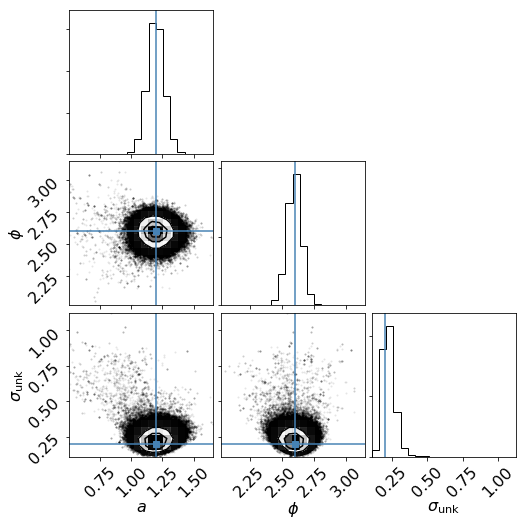

In [13]:
import corner
fig = corner.corner(samples, labels=["$a$", "$\\phi$", "$\\sigma_\\mathrm{unk}$"],
                      truths=[a_t, phi_t, unsys])

In [14]:
samples[:, 2] = np.exp(samples[:, 2])
a_mcmc, phi_mcmc, sig_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

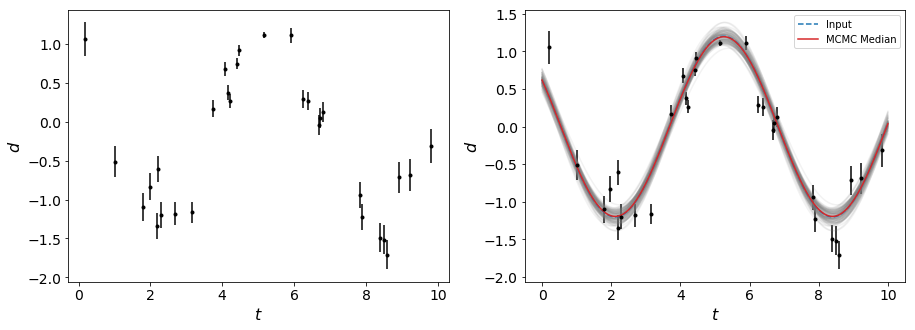

In [15]:
plt.rcParams["font.size"] = 10
fig=plt.figure(figsize=(15,5))
ax=fig.add_subplot(121)
ax.errorbar(x,y,yerr=knownstd,color="black",fmt=".k")
plt.tick_params(labelsize=14)
pylab.xlabel("$t$",fontsize=16)
pylab.ylabel("$d$",fontsize=16)
ax=fig.add_subplot(122)
for a, phi, sig in samples[np.random.randint(len(samples), size=100)]:
    ax.plot(xl, a*np.sin(xl+phi), color="gray", alpha=0.1)
#plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
ax.errorbar(x, y, yerr=knownstd, fmt=".k")
ax.plot(xl,ytrue,color="C0",ls="dashed",label="Input")
ax.plot(xl,a_mcmc[0]*np.sin(xl+phi_mcmc[0]),color="C3",label="MCMC Median")
plt.tick_params(labelsize=14)
pylab.xlabel("$t$",fontsize=16)
pylab.ylabel("$d$",fontsize=16)
ax.legend()
plt.show()